### Import Libraries

In [1]:
from pathlib import Path
import shutil
import os
import logging
import sys
import gc
sys.path.append('C:/Users/KAPLAN/Desktop/pytorch_examples/models/')
from pandas import DataFrame
from textblob import TextBlob
from pprint import pprint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')

import time
from transformers import AutoModelForSequenceClassification

from finbert.finbert import *
import finbert.utils as tools

%load_ext autoreload
%autoreload 2

project_dir = Path.cwd().parent
pd.set_option('max_colwidth', -1)

<ipython-input-1-6e9265c36784>:21: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


In [2]:
project_dir

WindowsPath('C:/Users/KAPLAN/Desktop')

In [3]:
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.ERROR)

In [28]:
lm_path = project_dir/'pytorch_examples'/'models'/'language_model'/'finbertTRC2'
cl_path = project_dir/'pytorch_examples'/'models'/'classifier_model'/'finbert_sentiment'
cl_data_path = project_dir/'pytorch_examples'/'models'/'data'/'sentiment_data'

## Configuring adapted functions

In [ ]:
def oneHot(row):
  if row=='negative': return -1
  if row=='neutral' : return  0
  if row=='positive' : return +1

In [612]:
def predict(text, model, write_to_csv=False, path=None):
    """
    Predict sentiments of sentences in a given text. The function first tokenizes sentences, make predictions and write
    results.
    Parameters
    ----------
    text: string
        text to be analyzed
    model: BertForSequenceClassification
        path to the classifier model
    write_to_csv (optional): bool
    path (optional): string
        path to write the string
    """
    model.eval()
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    sentences = text   
    label_list = ['positive', 'negative', 'neutral']
    label_dict = {0: 'positive', 1: 'negative', 2: 'neutral'}
    result = pd.DataFrame(columns=['sentence', 'logit', 'prediction', 'sentiment_score'])
    for batch in chunks(text, len(text)):
        examples = [InputExample(str(i), sentence) for i, sentence in enumerate(batch)]

        features = convert_examples_to_features(examples, label_list, 64, tokenizer)

        all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
        all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
        all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)

        with torch.no_grad():
            logits = model(all_input_ids, all_attention_mask, all_token_type_ids)[0]
            logging.info(logits)
            logits = softmax(np.array(logits))
            sentiment_score = pd.Series(logits[:, 0] - logits[:, 1])
            predictions = np.squeeze(np.argmax(logits, axis=1))

            batch_result = {'sentence': batch,
                            'logit': list(logits),
                            'prediction': predictions,
                            'sentiment_score': sentiment_score}

            batch_result = pd.DataFrame(batch_result)
            result = pd.concat([result, batch_result], ignore_index=True)

    result['prediction'] = result.prediction.apply(lambda x: label_dict[x])
    if write_to_csv:
        result.to_csv(path, sep=',', index=True)

    return result

## Configuring training parameters

In [5]:
# Clean the cl_path
try:
    shutil.rmtree(cl_path) 
except:
    pass

bertmodel = AutoModelForSequenceClassification.from_pretrained(lm_path,cache_dir=None, num_labels=3)


config = Config(   data_dir=cl_data_path,
                   bert_model=bertmodel,
                   num_train_epochs=4,
                   model_dir=cl_path,
                   max_seq_length = 48,
                   train_batch_size = 32,
                   learning_rate = 2e-5,
                   output_mode='classification',
                   warm_up_proportion=0.2,
                   local_rank=-1,
                   discriminate=True,
                   gradual_unfreeze=True)

In [6]:
finbert = FinBert(config)
finbert.base_model = 'bert-base-uncased'
finbert.config.discriminate=True
finbert.config.gradual_unfreeze=True

In [7]:
finbert.prepare_model(label_list=['positive','negative','neutral'])
class_names = ['positive','negative','neutral']

06/22/2021 16:50:52 - INFO - finbert.finbert -   device: cpu n_gpu: 0, distributed training: False, 16-bits training: False


In [8]:
train_data = finbert.get_data('train')

In [9]:
model = finbert.create_the_model()

In [10]:
from finbert.finbert import *
trained_model = finbert.train(train_examples = train_data, model = model)

06/22/2021 16:50:59 - INFO - finbert.utils -   *** Example ***
06/22/2021 16:50:59 - INFO - finbert.utils -   guid: train-1
06/22/2021 16:50:59 - INFO - finbert.utils -   tokens: [CLS] will op ##ec cut oil production ? [SEP]
06/22/2021 16:50:59 - INFO - finbert.utils -   input_ids: 101 2097 6728 8586 3013 3514 2537 1029 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/22/2021 16:50:59 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/22/2021 16:50:59 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/22/2021 16:50:59 - INFO - finbert.utils -   label: positive (id = 0)
06/22/2021 16:51:01 - INFO - finbert.finbert -   ***** Loading data *****
06/22/2021 16:51:01 - INFO - finbert.finbert -     Num examples = 18141
06/22/2021 16:51:01 - INFO - finbert.finbert -     Batch siz

06/22/2021 17:08:30 - INFO - finbert.utils -   *** Example ***
06/22/2021 17:08:30 - INFO - finbert.utils -   guid: validation-1
06/22/2021 17:08:30 - INFO - finbert.utils -   tokens: [CLS] libyan oil output plum ##met ##ing [SEP]
06/22/2021 17:08:30 - INFO - finbert.utils -   input_ids: 101 19232 3514 6434 22088 11368 2075 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/22/2021 17:08:30 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/22/2021 17:08:30 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/22/2021 17:08:30 - INFO - finbert.utils -   label: positive (id = 0)


06/22/2021 17:08:31 - INFO - finbert.finbert -   ***** Loading data *****
06/22/2021 17:08:31 - INFO - finbert.finbert -     Num examples = 6045
06/22/2021 17:08:31 - INFO - finbert.finbert -     Batch size = 32
06/22/2021 17:08:31 - INFO - finbert.finbert -     Num steps = 752



Validation losses: [0.24517585155825136]
No best model found


Epoch:  25%|██▌       | 1/4 [21:10<1:03:30, 1270.01s/it]

06/22/2021 17:35:50 - INFO - finbert.utils -   *** Example ***
06/22/2021 17:35:50 - INFO - finbert.utils -   guid: validation-1
06/22/2021 17:35:50 - INFO - finbert.utils -   tokens: [CLS] libyan oil output plum ##met ##ing [SEP]
06/22/2021 17:35:50 - INFO - finbert.utils -   input_ids: 101 19232 3514 6434 22088 11368 2075 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/22/2021 17:35:50 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/22/2021 17:35:50 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/22/2021 17:35:50 - INFO - finbert.utils -   label: positive (id = 0)


06/22/2021 17:35:50 - INFO - finbert.finbert -   ***** Loading data *****
06/22/2021 17:35:50 - INFO - finbert.finbert -     Num examples = 6045
06/22/2021 17:35:50 - INFO - finbert.finbert -     Batch size = 32
06/22/2021 17:35:50 - INFO - finbert.finbert -     Num steps = 752



Validation losses: [0.24517585155825136, 0.11493430655725577]


Epoch:  50%|█████     | 2/4 [48:37<46:06, 1383.12s/it]  

06/22/2021 18:09:36 - INFO - finbert.utils -   *** Example ***
06/22/2021 18:09:36 - INFO - finbert.utils -   guid: validation-1
06/22/2021 18:09:36 - INFO - finbert.utils -   tokens: [CLS] libyan oil output plum ##met ##ing [SEP]
06/22/2021 18:09:36 - INFO - finbert.utils -   input_ids: 101 19232 3514 6434 22088 11368 2075 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/22/2021 18:09:36 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/22/2021 18:09:36 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/22/2021 18:09:36 - INFO - finbert.utils -   label: positive (id = 0)


06/22/2021 18:09:37 - INFO - finbert.finbert -   ***** Loading data *****
06/22/2021 18:09:37 - INFO - finbert.finbert -     Num examples = 6045
06/22/2021 18:09:37 - INFO - finbert.finbert -     Batch size = 32
06/22/2021 18:09:37 - INFO - finbert.finbert -     Num steps = 752



Validation losses: [0.24517585155825136, 0.11493430655725577, 0.08152314423332138]


Epoch:  75%|███████▌  | 3/4 [1:22:24<26:16, 1576.51s/it]

06/22/2021 18:48:58 - INFO - finbert.utils -   *** Example ***
06/22/2021 18:48:58 - INFO - finbert.utils -   guid: validation-1
06/22/2021 18:48:58 - INFO - finbert.utils -   tokens: [CLS] libyan oil output plum ##met ##ing [SEP]
06/22/2021 18:48:58 - INFO - finbert.utils -   input_ids: 101 19232 3514 6434 22088 11368 2075 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/22/2021 18:48:58 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/22/2021 18:48:58 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/22/2021 18:48:58 - INFO - finbert.utils -   label: positive (id = 0)


06/22/2021 18:48:59 - INFO - finbert.finbert -   ***** Loading data *****
06/22/2021 18:48:59 - INFO - finbert.finbert -     Num examples = 6045
06/22/2021 18:48:59 - INFO - finbert.finbert -     Batch size = 32
06/22/2021 18:48:59 - INFO - finbert.finbert -     Num steps = 752



Validation losses: [0.24517585155825136, 0.11493430655725577, 0.08152314423332138, 0.07550388838967713]


Epoch: 100%|██████████| 4/4 [2:01:49<00:00, 1827.48s/it]


In [11]:
test_data = finbert.get_data('test')

In [12]:
results = finbert.evaluate(examples=test_data, model=trained_model)

06/22/2021 18:54:24 - INFO - finbert.utils -   *** Example ***
06/22/2021 18:54:24 - INFO - finbert.utils -   guid: test-1
06/22/2021 18:54:24 - INFO - finbert.utils -   tokens: [CLS] update 1 - s . korea ' s jan u . s . crude imports rise 53 . 3 % on - year [SEP]
06/22/2021 18:54:24 - INFO - finbert.utils -   input_ids: 101 10651 1015 1011 1055 1012 4420 1005 1055 5553 1057 1012 1055 1012 13587 17589 4125 5187 1012 1017 1003 2006 1011 2095 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/22/2021 18:54:24 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/22/2021 18:54:24 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/22/2021 18:54:24 - INFO - finbert.utils -   label: positive (id = 0)
06/22/2021 18:54:25 - INFO - finbert.finbert -   ***** Loading data *****
06/22/2021 18:54:25 - INFO - finbert.finb

In [14]:
results['prediction'] = results.predictions.apply(lambda x: np.argmax(x,axis=0))

In [ ]:
y_test = results['labels'] 
y_pred = results['prediction']

def report(df, cols=['label','prediction','logits']):
    #print('Validation loss:{0:.2f}'.format(metrics['best_validation_loss']))
    cs = CrossEntropyLoss(weight=finbert.class_weights)
    loss = cs(torch.tensor(list(df[cols[2]])),torch.tensor(list(df[cols[0]])))
    print("Loss:{0:.2f}".format(loss))
    print("Accuracy:{0:.2f}".format((df[cols[0]] == df[cols[1]]).sum() / df.shape[0]) )
    print("\nClassification Report:")
    print(classification_report(df[cols[0]], df[cols[1]]))

In [15]:
report(results,cols=['labels','prediction','predictions'])

06/22/2021 18:58:27 - INFO - numexpr.utils -   Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
06/22/2021 18:58:27 - INFO - numexpr.utils -   NumExpr defaulting to 8 threads.


Loss:0.11
Accuracy:0.97

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      3126
           1       0.97      0.98      0.97      2812
           2       0.96      0.96      0.96       107

    accuracy                           0.97      6045
   macro avg       0.97      0.97      0.97      6045
weighted avg       0.97      0.97      0.97      6045



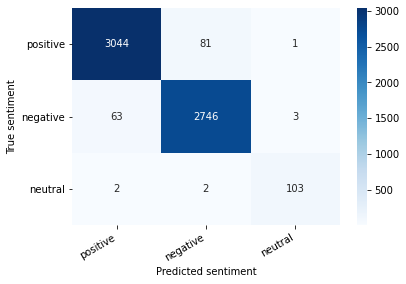

In [595]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

## Load the pre-trained Model

In [17]:
model = AutoModelForSequenceClassification.from_pretrained(cl_path, cache_dir=None, num_labels=3)

## Or import already pre-trained Model

In [ ]:
model_finbert = BertForSequenceClassification.from_pretrained('model_test/pytorch_model.bin',config='model_test/config.json',num_labels=3)
model_crudebert = BertForSequenceClassification.from_pretrained('model_test/crude_bert_model.bin',config='model_test/crude_bert_config.json',num_labels=3)

## Save pre-trained Model

In [573]:
import torch

torch_path ="C:/Users/KAPLAN/Desktop/pytorch_examples/models/CrudeBERT_model"
torch.save(model.state_dict(), os.path.join(torch_path, "crudebert.pth"))

# Read Headlines

In [ ]:
news = pd.read_excel("news.xlsx",parse_dates=[['Date', 'Time']], engine='openpyxl')

In [18]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KAPLAN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Clear Ram with gc (garbage collector)

gc.collect()

#del my_array
#del my_object
#gc.collect()

### Slice dataframe if it is to big for the RAM

In [409]:
news_text_first_quarter = news.Headline[:int(len(news.Headline)/4)]

In [450]:
news_text_second_quarter = news.Headline[int(len(news.Headline)/4):int(len(news.Headline)/2)]

In [411]:
news_text_third_quarter = news.Headline[int(len(news.Headline)/2):int(len(news.Headline)/4)*3]

In [412]:
news_text_fourth_quarter = news.Headline[int(len(news.Headline)/4)*3:]

### Verify if sum of slices have the same size as the unsliced dataframe

In [597]:
len(news) == len(news_text_first_quarter) + len(news_text_second_quarter) + len(news_text_third_quarter) + len(news_text_fourth_quarter)

True

### Check with a small sample first

In [602]:
sample = news.Headline[:50]

In [610]:
sample.head()

0    India Apr-Nov Oil Imports $6.20B Vs $4.03B; +53.86%                                                                                                                                                 
1    Texaco and Chevron Missed the Boat on Big Stock Gains --- Their Returns Were Stagnant as Oil Prices Soared Amid Mergers Among Rivals ---- By Steve Liesman Staff Reporter of The Wall Street Journal
2    Taiwan CPC Dec Crude Oil Imports 20.4M Bbl, US$23.79/Bbl                                                                                                                                            
3    Midday US Spot Crude: Prices Sink With Crude Futures                                                                                                                                                
4    API: US Crude Stocks Dn 1.568 Mln Bbl In Week                                                                                                                                              

In [430]:
df_sample

,sentence,logit,prediction,sentiment_score
0,India Apr-Nov Oil Imports $6.20B Vs $4.03B; +53.86%,"[0.98235655, 0.015724735, 0.0019187173]",positive,0.966632
1,Texaco and Chevron Missed the Boat on Big Stock Gains --- Their Returns Were Stagnant as Oil Prices Soared Amid Mergers Among Rivals ---- By Steve Liesman Staff Reporter of The Wall Street Journal,"[0.98221946, 0.016272597, 0.0015078676]",positive,0.965947
2,"Taiwan CPC Dec Crude Oil Imports 20.4M Bbl, US$23.79/Bbl","[0.98791003, 0.00866582, 0.0034241425]",positive,0.979244
3,Midday US Spot Crude: Prices Sink With Crude Futures,"[0.0085255215, 0.99080503, 0.00066945667]",negative,-0.982279
4,API: US Crude Stocks Dn 1.568 Mln Bbl In Week,"[0.99268323, 0.006358306, 0.0009585765]",positive,0.986325
5,Nymex Access Crude Down After 4th Straight Day Of Losses,"[0.0068248343, 0.9923463, 0.00082892954]",negative,-0.985521
6,China's CNPC '99 Crude Output 107.08M MT; Dn 0.3%,"[0.4947401, 0.49652705, 0.008732811]",negative,-0.001787
7,Late US Spot Crude: Prices Lower After Choppy Day,"[0.0050258995, 0.99266386, 0.0023102001]",negative,-0.987638
8,WSJ(1/7): Texaco Says Oil Find May Hold A Billion Barrels,"[0.0022811445, 0.99659216, 0.001126783]",negative,-0.994311
9,Nymex Midmorning:Crude Dn On Report Of Higher OPEC Output,"[0.008583628, 0.99056774, 0.0008487068]",negative,-0.981984


### Perform Sentiment Analysis on each slice

In [418]:
start_time = time.time()
df_analyzed_news_text_first_quarter = predict(news_text_first_quarter , model)
print(" Time passed: {} seconds ".format(time.time() - start_time))

06/23/2021 15:31:05 - INFO - finbert.utils -   *** Example ***
06/23/2021 15:31:05 - INFO - finbert.utils -   guid: 0
06/23/2021 15:31:05 - INFO - finbert.utils -   tokens: [CLS] india apr - nov oil imports $ 6 . 20 ##b vs $ 4 . 03 ##b ; + 53 . 86 % [SEP]
06/23/2021 15:31:05 - INFO - finbert.utils -   input_ids: 101 2634 19804 1011 13292 3514 17589 1002 1020 1012 2322 2497 5443 1002 1018 1012 6021 2497 1025 1009 5187 1012 6564 1003 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/23/2021 15:31:05 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/23/2021 15:31:05 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/23/2021 15:31:05 - INFO - finbert.utils -   label: None (id = 9090)
06/23/2021 15:38:25 - INFO - 

 Time passed: 443.20300555229187 seconds 


In [454]:
start_time = time.time()
news_text_second_quarter = news_text_second_quarter.reset_index(drop=True) #avoids conflict with len of df and expected index
df_analyzed_news_text_second_quarter = predict(news_text_second_quarter , model)
print(" Time passed: {} seconds ".format(time.time() - start_time))

06/23/2021 16:45:33 - INFO - finbert.utils -   *** Example ***
06/23/2021 16:45:33 - INFO - finbert.utils -   guid: 0
06/23/2021 16:45:33 - INFO - finbert.utils -   tokens: [CLS] china jun crude oil exports 1 . 42 ml ##n tons , + 550 % - source [SEP]
06/23/2021 16:45:33 - INFO - finbert.utils -   input_ids: 101 2859 12022 13587 3514 14338 1015 1012 4413 19875 2078 6197 1010 1009 13274 1003 1011 3120 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/23/2021 16:45:33 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/23/2021 16:45:33 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/23/2021 16:45:33 - INFO - finbert.utils -   label: None (id = 9090)
06/23/2021 16:53:04 - INFO - root -   tensor([[-1.

 Time passed: 453.31520223617554 seconds 


In [456]:
start_time = time.time()
news_text_third_quarter = news_text_third_quarter.reset_index(drop=True)
df_analyzed_news_text_third_quarter = predict(news_text_third_quarter , model)
print(" Time passed: {} seconds ".format(time.time() - start_time))

06/23/2021 16:53:26 - INFO - finbert.utils -   *** Example ***
06/23/2021 16:53:26 - INFO - finbert.utils -   guid: 0
06/23/2021 16:53:26 - INFO - finbert.utils -   tokens: [CLS] officials : pirates seize oil tanker in ivory coast [SEP]
06/23/2021 16:53:26 - INFO - finbert.utils -   input_ids: 101 4584 1024 8350 15126 3514 20135 1999 11554 3023 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/23/2021 16:53:26 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/23/2021 16:53:26 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/23/2021 16:53:26 - INFO - finbert.utils -   label: None (id = 9090)
06/23/2021 17:00:37 - INFO - root -   tensor([[ 2.9490, -0.5531, -4.1644],
        [ 3.469

 Time passed: 433.68320775032043 seconds 


In [458]:
start_time = time.time()
news_text_fourth_quarter =news_text_fourth_quarter.reset_index(drop=True)
df_analyzed_news_text_fourth_quarter = predict(news_text_fourth_quarter , model)
print(" Time passed: {} seconds ".format(time.time() - start_time))

06/23/2021 17:00:47 - INFO - finbert.utils -   *** Example ***
06/23/2021 17:00:47 - INFO - finbert.utils -   guid: 0
06/23/2021 17:00:47 - INFO - finbert.utils -   tokens: [CLS] bloomberg brief : kuwait & uae oil production cuts ( audio ) [SEP]
06/23/2021 17:00:47 - INFO - finbert.utils -   input_ids: 101 22950 4766 1024 13085 1004 17641 3514 2537 7659 1006 5746 1007 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/23/2021 17:00:47 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/23/2021 17:00:47 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
06/23/2021 17:00:47 - INFO - finbert.utils -   label: None (id = 9090)
06/23/2021 17:08:01 - INFO - root -   tensor([[ 3.8453, -2.2750, -3.4834

 Time passed: 436.715145111084 seconds 


### Concatenate the slices

In [460]:
quarters = [df_analyzed_news_text_first_quarter, df_analyzed_news_text_second_quarter, df_analyzed_news_text_third_quarter, df_analyzed_news_text_fourth_quarter]
df_analyzed_news_text_full = pd.concat(quarters)
df_analyzed_news_text_full = df_analyzed_news_text_full.reset_index(drop=True)

### Verify if sum of concatenated slices have the same size as the initial dataframe

In [467]:
#Check if same size
len(news) == len(df_analyzed_news_text_full)

True

### Apply the binary sentiment scores neg = -1, neu = 0, pos = 1 (Optional)

In [496]:
sentiment_score_binary = df_analyzed_news_text_full.prediction.apply(oneHot)
sentiment_score_binary = sentiment_score_binary.reset_index(drop=True)
df_analyzed_news_text_full['sentiment_score_binary'] = sentiment_score_binary

In [501]:
df_analyzed_news_text_full

,sentence,logit,prediction,sentiment_score,sentiment_score_binary
0,India Apr-Nov Oil Imports $6.20B Vs $4.03B; +53.86%,"[0.98235655, 0.015724735, 0.0019187173]",positive,0.966632,1
1,Texaco and Chevron Missed the Boat on Big Stock Gains --- Their Returns Were Stagnant as Oil Prices Soared Amid Mergers Among Rivals ---- By Steve Liesman Staff Reporter of The Wall Street Journal,"[0.98221946, 0.016272597, 0.0015078676]",positive,0.965947,1
2,"Taiwan CPC Dec Crude Oil Imports 20.4M Bbl, US$23.79/Bbl","[0.98791003, 0.00866582, 0.0034241425]",positive,0.979244,1
3,Midday US Spot Crude: Prices Sink With Crude Futures,"[0.0085255215, 0.99080503, 0.00066945667]",negative,-0.982279,-1
4,API: US Crude Stocks Dn 1.568 Mln Bbl In Week,"[0.99268323, 0.006358306, 0.0009585765]",positive,0.986325,1
...,...,...,...,...,...
11475,U.S. oil production to start rising in second quarter: Kemp,"[0.0014707955, 0.9970573, 0.0014719104]",negative,-0.995587,1
11476,OPEC+ to increase oil production from May,"[0.0012697678, 0.9963229, 0.0024074274]",negative,-0.995053,1
11477,OPEC+ to Ease Oil Output Cuts in Cautious Bet on Recovery,"[0.9952425, 0.003760195, 0.0009973103]",positive,0.991482,-1
11478,Iraq's crude oil exports exceed 91 mln barrels in March,"[0.002145525, 0.9967258, 0.0011286802]",negative,-0.994580,1


###  Save the dataframe

In [ ]:
df_analyzed_news_text_full.to_excel("df_analyzed_news_text_full.xlsx")